In [1]:
import community_simulator as comsim

from community_simulator.usertools import *
from community_simulator.visualization import *

import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt

# Seed the generator so we get repeatable results
np.random.seed(1234)
!mkdir -p ../output/082121_heterogenous_w_1tournament

# Overview
Pankaj says we should be able to get weak linear increase in species diversity with number of resources, as in Martina's new paper, if there is a lot of heterogeneity in energy content of resources. In this notebook I tried two setups - first I assume that there very 4 resource classes with very distinct energy levels.

Class 1: poly-saccharides have the highest energy content
Class 2: mono-saccharides and sugar derivatives (sugar alcohols, sugar acids) have medium energy content
Class 3: short-chain organic acids have lower energy content
Class 4: CO2 is the sole terminal waste product, lowest energy content 

In the first run of the model I assume that this energy hierarchy is the only information we add to the CRM. In the second run I construct a metabolic matrix that follows some crude stoichiometric rules where each molecule has a stoichiometry (i.e. number of C atoms) and secreted products tend to have lower stoichiometry.

I didn't manage to recapitulate Martina's results in either case, which suggests to me that I am using the community simulator incorrectly. 

In [2]:
# Just leaving this here for my own reference
assumptions_defaults = {
    'sampling':'Binary', #{'Gaussian','Binary','Gamma'} specifies choice of sampling algorithm
    'SA': 60*np.ones(3), #Number of species in each specialist family (here, 3 families of 60 species)
    'MA': 30*np.ones(3), #Number of resources in each class 
    'Sgen': 30, #Number of generalist species (unbiased sampling over alll resource classes)
    'muc': 10, #Mean sum of consumption rates (used in all models)
    'sigc': 3, #Standard deviation of sum of consumption rates for Gaussian and Gamma models
    'q': 0.0, #Preference strength of specialist families (0 for generalist and 1 for specialist)
    'c0':0.0, #Sum of background consumption rates in binary model
    'c1':1., #Specific consumption rate in binary model
    'l':0.8, #Leakage fraction
    'fs':0.45, #Fraction of secretion flux with same resource type
    'fw':0.45, #Fraction of secretion flux to 'waste' resource
    'sparsity':0.2, #Effective sparsity of metabolic matrix (between 0 and 1)
    'n_wells':10, #Number of independent wells
    'S':100, #Number of species per well (randomly sampled from the pool of size Stot = sum(SA) + Sgen)
    'food':0, #index of food source (when a single resource is supplied externally)
    'R0_food':1000, #unperturbed fixed point for supplied food
    'regulation':'independent', #metabolic regulation (see dRdt)
    'response':'type I', #functional response (see dRdt)
    'supply':'off' #resource supply (see dRdt)
}

In [3]:
# Start with default parameters
assumptions = a_default.copy()

# Four resource classes described above
n_r_classes = 4
n_r_per_class = 30
MA = np.array([30, 30, 30, 1])
assumptions['MA'] = MA
n_r = int(assumptions['MA'].sum())

# Assign a medium leakage fraction
assumptions['l'] = 0.4

# Most of the leakage is of the "waste" type i.e. CO2
assumptions['fs'] = 0.25
assumptions['fw'] = 0.5

# We will test mixes of 1, 2, 4, 8, and 16 resource mixes as in the paper.
# 50 wells means we do 10 of each resource count. 
n_wells = 200
assumptions['n_wells'] = n_wells

# Constant total food supply level.
R0_food = 20
assumptions['R0_food'] = R0_food
assumptions['supply'] = 'external'

# Here we assume energy is ~uniformly distributed within the 4 classes, but each class
# is very separated by its resources energy content. Roughly: 
# Class 0: poly/di-saccharides, highest energy content
# Class 1: mono-saccharides and sugar alcohols, medium energy content.
# Class 2: organic acids, low energy content.
# Class 3: CO2 as the terminal waste carbon product.
class_0_w = np.random.choice(np.arange(1000, 1200), MA[0])
class_1_w = np.random.choice(np.arange(500, 600), MA[1])
class_2_w = np.random.choice(np.arange(300, 400), MA[2])
class_3_w = np.random.choice(np.arange(100, 200), MA[3])

w_vec = np.concatenate([class_0_w, class_1_w, class_2_w, class_3_w])
assumptions['w'] = w_vec
print('Stoichiometric w vector', w_vec)

# Construct matrices
c,D = MakeMatrices(assumptions)

# Make initial state
N0, R0 = MakeInitialState(assumptions)

# Modify the R0 matrix to make multiple food sources.
R0_prime = np.zeros(np.shape(R0))

# Model has 91 number of "resources" of 4 classes. Martina supplies a small subset of 16 in various combinations.
# We pick a small number from each class to get 16, emphasing class 1 due to the prevalence of sugars. 
# Don't provide CO2 (waste) i.e. nothing from the last class. 
food_order = np.array(
    list(range(4)) + list(range(30, 40)) + list(range(60, 64)))
print('Food order', food_order)

# 5 numbers of C sources ("tournament style").
n_foods = np.power(2, np.arange(5))
n_rounds = 1  # increase for more tournaments
for round_idx in np.arange(n_rounds):
    for iteration, n_food in enumerate(n_foods):
        # 40 wells for each number of resources
        for j in range(40):
            # Randomize the carbon sources supplied, pick the first n_food of them
            np.random.shuffle(food_order)
            food_idx = food_order[np.arange(n_food)]
            well = round_idx*200 + iteration*40 + j
            R0_prime[food_idx,well] = R0_food

# Rescale so that the R0 sums to R0_food for all wells.
R0_prime /= R0_prime.sum(axis=0) 
R0_prime *= R0_food
R0_prime = pd.DataFrame(R0_prime, index=D.index, columns=N0.keys())

# Make dynamics
def dNdt(N,R,params):
    return MakeConsumerDynamics(assumptions)(N,R,params)
def dRdt(N,R,params):
    return MakeResourceDynamics(assumptions)(N,R,params)
dynamics = [dNdt,dRdt]

# Make parameters
params = MakeParams(assumptions)

R0_prime.head(5)

Stoichiometric w vector [1047 1038 1053 1116 1152 1143 1177 1023 1154 1030 1171 1158 1124 1026
 1118 1186 1120 1112 1069 1080 1127 1175 1050 1076 1037 1034 1166 1195
 1139 1128  575  580  503  502  519  512  565  575  581  514  571  560
  546  528  581  587  513  596  512  569  595  531  589  584  545  516
  541  572  556  570  356  386  344  390  383  347  349  318  385  346
  398  337  338  307  367  305  347  347  315  334  310  328  304  382
  389  355  378  323  350  362  155]
Food order [ 0  1  2  3 30 31 32 33 34 35 36 37 38 39 60 61 62 63]


W0   W1   W2    W3    W4   W5   W6   W7   W8   W9  ...  W190  W191  \
T0 R0   0.0  0.0  0.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0  ...  1.25  1.25   
   R1   0.0  0.0  0.0   0.0  20.0  0.0  0.0  0.0  0.0  0.0  ...  1.25  1.25   
   R2  20.0  0.0  0.0  20.0   0.0  0.0  0.0  0.0  0.0  0.0  ...  0.00  1.25   
   R3   0.0  0.0  0.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0  ...  1.25  1.25   
   R4   0.0  0.0  0.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0  ...  0.00  0.00   

       W192  W193  W194  W195  W196  W197  W198  W199  
T0 R0  1.25  1.25  1.25  1.25  1.25  1.25  0.00  1.25  
   R1  1.25  1.25  0.00  1.25  1.25  1.25  1.25  1.25  
   R2  1.25  1.25  1.25  1.25  1.25  1.25  1.25  1.25  
   R3  1.25  1.25  0.00  1.25  1.25  1.25  1.25  1.25  
   R4  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  

[5 rows x 200 columns]

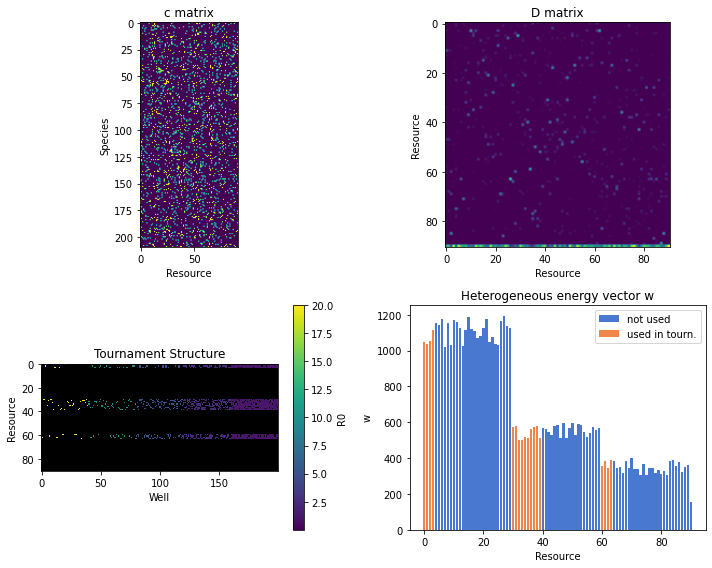

In [4]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(10,8))
pal = sns.color_palette('muted')
cmap = plt.get_cmap('viridis').copy()
cmap.set_under(color='black')

plt.sca(axs[0, 0])
plt.imshow(c, cmap='viridis')
plt.title('c matrix')
plt.xlabel('Resource')
plt.ylabel('Species')

plt.sca(axs[0, 1])
plt.imshow(D, cmap='viridis')
plt.title('D matrix')
plt.xlabel('Resource')
plt.ylabel('Resource')

plt.sca(axs[1, 0])
plt.imshow(R0_prime, cmap=cmap, vmin=1e-8, interpolation='none')
plt.title('Tournament Structure')
plt.xlabel('Well')
plt.ylabel('Resource')
plt.colorbar(label='R0')

plt.sca(axs[1,1])
resources_used = np.where((R0_prime > 0).any(axis=1))
xs = np.arange(len(w_vec))
plt.bar(np.arange(len(w_vec)), w_vec, color=pal[0], label='not used')
plt.bar(xs[resources_used], w_vec[resources_used], color=pal[1], label='used in tourn.')
plt.legend(loc=1)
plt.xlabel('Resource')
plt.ylabel('w')
plt.title('Heterogeneous energy vector w')
plt.tight_layout()
plt.savefig('../output/082121_heterogenous_w_1tournament/exp_setup.png',
            facecolor='w', dpi=600)
plt.show()

In [5]:
# Initialize plate
plate1 = comsim.Community(
    (N0, R0_prime), dynamics, params,
    parallel=False)

# Run experiment as in Martina's paper
transfer_matrix = np.eye(n_wells)/30.0
res = plate1.RunExperiment(transfer_matrix,24,7,
                           refresh_resource=True)

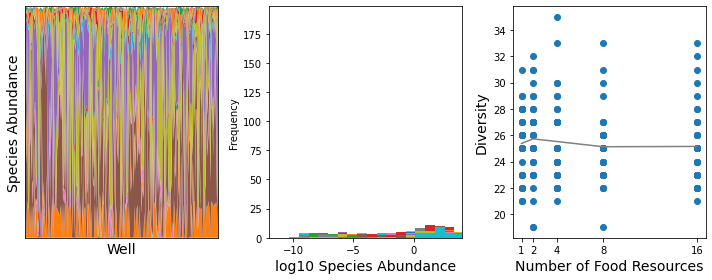

In [14]:
# Plot community compositions
fig,axs = plt.subplots(ncols=3, figsize=(10,4))

plt.sca(axs[0])

StackPlot(plate1.N, ax=axs[0])
plt.xlabel('Well',fontsize=14)
plt.ylabel('Species Abundance',fontsize=14)

# Make histogram of all population sizes
plt.sca(axs[1])
np.log10(plate1.N+1e-20).plot.hist(ax=axs[1], bins=30, legend=False)
plt.xlim((-12,4))
plt.xlabel('log10 Species Abundance', fontsize=14)

# Plot diversity
plt.sca(axs[2])
xs = (R0_prime > 0).sum(axis=0)
plt.scatter(xs, (plate1.N>1e-4).sum().values)
plt.plot(sorted(set(xs)), (plate1.N > 1e-4).groupby(xs, axis=1).mean().sum(),
         color='grey')
plt.xticks(n_foods)
plt.xlabel('Number of Food Resources', fontsize=14)
plt.ylabel('Diversity', fontsize=14)

plt.tight_layout()
plt.savefig('../output/082121_heterogenous_w_1tournament/tournament_results.png',
            facecolor='w', dpi=600)
plt.show()

In [8]:
# Loosely taking off of Martina's paper
# 4 classes of resources - 
# 1. dimers of sugars (ignoring polymers) - 12C, 18C, 24C
# 2. sugars, sugar alcohols - 6C, 3C
# 3. carboxylic acids - 2C, 3C, 4C
# 4. CO2 as a terminal 1C waste product
# Ignoring the hydroxyproline, cellulose/starch, and galacturonate.

# Encode allowed stoichiometries.
r_stoichiometries = {0: [24, 18, 12],
                     1: [6, 3],
                     2: [2, 3, 4],
                     3: [1]}

# Transformations between classes are allowed if encoded here and conserve mass.
r_class_transformations = {0: [0, 1, 2, 3],
                           1: [1, 2, 3],
                           2: [2, 3],
                           3: []}

# Trying to encode 2 constraints in the model.
# a. conservation of C atoms
# b. energy/redox hierarchy among resources
# (b) was already done above. now need to do (a)
n_r_classes = 4
n_r_per_class = [30, 30, 30, 1]
r_classes = np.concatenate(
    [np.ones(nr, dtype=np.int32)*i for i, nr in enumerate(n_r_per_class)])
r_stoich = np.concatenate(
    [np.random.choice(r_stoichiometries[i], nr)
     for i, nr in enumerate(n_r_per_class)])

n_r_total = np.array(n_r_per_class).sum()
D_prime = np.zeros((n_r_total,n_r_total))
mean_products, std_products = 10, 2

for i, (rc, rs) in enumerate(zip(r_classes, r_stoich)):
    allowed_classes = r_class_transformations[rc]
    if not allowed_classes:
        # Considering CO2 equivalent, has not further deg. products
        continue
        
    base_mask = np.isin(r_classes, allowed_classes)
    remaining_stoich = rs
    while remaining_stoich > 0:
        # Can only pick outputs that obey stoichiometric rules.
        mask = np.logical_and(base_mask, r_stoich <= remaining_stoich)
        allowed_trans_idxs = np.where(mask)[0]
        
        # Pick a single output metabolite at a time.
        r_out_idx = np.random.choice(allowed_trans_idxs, 1)[0]
        r_out_stoich = r_stoich[r_out_idx]
        D_prime[i, r_out_idx] += 1
        # Keep track of how many "atoms" are left
        remaining_stoich -= r_out_stoich

D_prime_stoich = pd.DataFrame(D_prime.T, index=D.index, columns=D.columns)

In [9]:
# Expect equal stoichiometry of input and output except for index 90, CO2
expected = np.zeros(91)
expected[-1] = -1
assert(((D_prime * r_stoich).sum(axis=1) - r_stoich == expected).all())
assert(((D_prime_stoich.T * r_stoich).sum(axis=1) - r_stoich == expected).all())

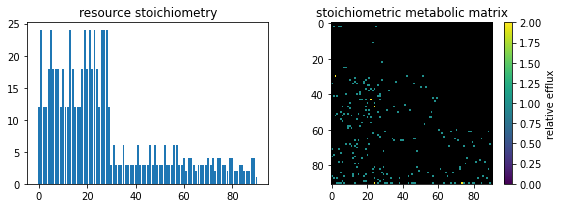

In [10]:
fig, axs = plt.subplots(ncols=2, figsize=(8,3))

plt.sca(axs[0])
plt.bar(np.arange(r_stoich.size), r_stoich)
plt.title('resource stoichiometry')

plt.sca(axs[1])
plt.imshow(D_prime_stoich, interpolation='none', cmap=cmap, vmin=1e-10)
plt.colorbar(label='relative efflux')
plt.title('stoichiometric metabolic matrix')

plt.tight_layout()
plt.savefig('../output/082121_heterogenous_w_1tournament/stoichiometric_matrix.png',
            facecolor='w', dpi=600)
plt.show()

In [11]:
params['D'] = D_prime_stoich

# Initialize plate
plate2 = comsim.Community(
    (N0, R0_prime), dynamics, params,
    parallel=False)

# Run experiment as in Martina's paper
transfer_matrix = np.eye(n_wells)/30.0
res = plate2.RunExperiment(transfer_matrix,24,7,
                           refresh_resource=True)

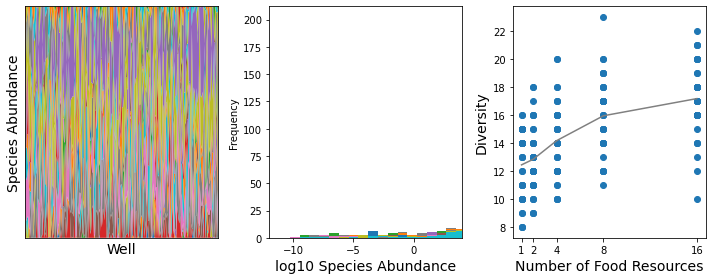

In [15]:
# Plot community compositions
fig,axs = plt.subplots(ncols=3, figsize=(10,4))

plt.sca(axs[0])

StackPlot(plate2.N, ax=axs[0])
plt.xlabel('Well',fontsize=14)
plt.ylabel('Species Abundance',fontsize=14)

# Make histogram of all population sizes
plt.sca(axs[1])
np.log10(plate2.N+1e-20).plot.hist(ax=axs[1], bins=30, legend=False)
plt.xlim((-12,4))
plt.xlabel('log10 Species Abundance', fontsize=14)

# Plot diversity
plt.sca(axs[2])
xs = (R0_prime > 0).sum(axis=0)
plt.scatter(xs, (plate2.N>1e-4).sum().values)
plt.plot(sorted(set(xs)), (plate2.N > 1e-4).groupby(xs, axis=1).mean().sum(),
         color='grey')
plt.xticks(n_foods)
plt.xlabel('Number of Food Resources', fontsize=14)
plt.ylabel('Diversity', fontsize=14)

plt.tight_layout()
plt.savefig('../output/082121_heterogenous_w_1tournament/tournament_results_stoich.png',
            facecolor='w', dpi=600)
plt.show()